In [1]:
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "svg"

from helpers.db_connection import DBConnect

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

### start by comparing political map

In [2]:
party_state_year_q = """
WITH t AS
(
	SELECT
		s.`state`,
		v.`year`,
		s.`party`,
		COUNT(DISTINCT s.`senator_id`) AS cnt
	FROM senators s
	JOIN votes v ON v.`senator_id` = s.`senator_id`
	GROUP BY s.`state`, v.`year`, s.`party`
)


SELECT 
	m.`state`, 
	m.`year`, 
	CASE WHEN t.cnt=1 THEN 'Tie' ELSE t.`party` END AS party
FROM (
	SELECT
		t.`state`,
		t.`year`,
		max(t.`cnt`) as max_cnt
	FROM t
	GROUP BY t.`state`, t.`year`
) m
JOIN t ON t.`state` = m.`state` 
	AND t.`year` = m.`year` 
	AND m.`max_cnt` = t.`cnt`
;
"""

In [3]:
with DBConnect('senate') as cnx:
    state_parties = pd.read_sql(con=cnx.cnx, sql=party_state_year_q)

In [4]:
state_parties = state_parties.loc[state_parties['party']!='Vice President', :]

In [5]:
import gif

def plot_map(y):
    parties_y = state_parties.loc[state_parties['year']==y, :]
    fig = px.choropleth(locations=parties_y['state'], locationmode="USA-states", color=parties_y['party'], scope="usa",
                    color_discrete_map={'Republican': 'red', 'Democrat': 'blue', 'Independent': 'purple', 'Tie': 'gray'}, 
                        title="Senate Majority by State: {}".format(str(y)))
    return fig

@gif.frame
def plot_map_to_gif(y):
    return plot_map(y)


years = range(1989, 2021)
# Construct list of frames
frames = []
for y in years:
    frame = plot_map_to_gif(y)
    frames.append(frame)

# Save gif from frames with a specific duration for each frame in ms

gif.save(frames, 'images/senate_map_animation.gif', duration=1000)



<img src="images/senate_map_animation.gif" width="750" align="center">

### Compare 1989 to 2020

In [6]:
parties_1989 = state_parties.loc[state_parties['year']==1989, :]
parties_2020 = state_parties.loc[state_parties['year']==2020, :]

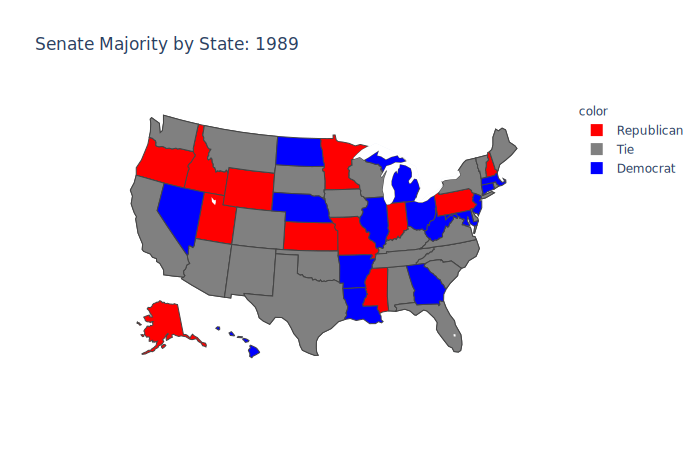

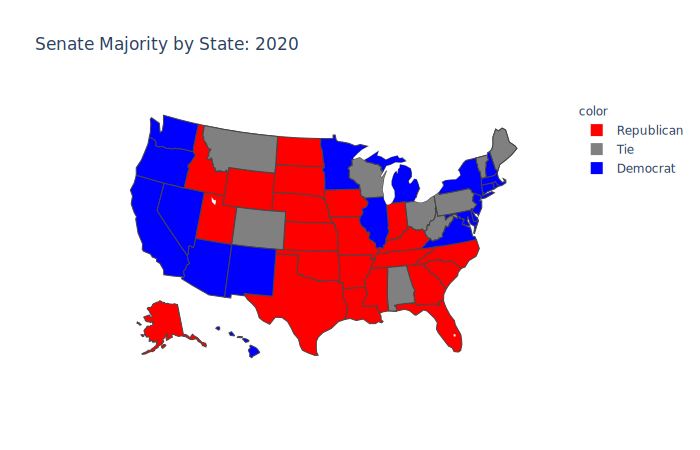

In [7]:
f1 = plot_map(1989)
f1.show()
f2 = plot_map(2020)
f2.show()

We go from having 23 "Tie" states in 1989 to having only 9 in 2020, which indicates stronger partisanship at the state level.

## Compare number of "party line" votes

In [8]:
party_line_votes_q = """
WITH t AS (
SELECT
	v.`year`,
	v.`congress`,
	v.`vote_number`,
	COUNT(CASE WHEN s.party = 'Republican' AND v.`vote` = 'Yea' THEN v.`vote` END) AS rep_y_count,
    COUNT(CASE WHEN s.party = 'Republican' AND v.`vote` = 'Nay' THEN v.`vote` END) AS rep_n_count,
    COUNT(CASE WHEN s.party = 'Democrat' AND v.`vote` = 'Yea' THEN v.`vote` END) AS dem_y_count,
    COUNT(CASE WHEN s.party = 'Democrat' AND v.`vote` = 'Nay' THEN v.`vote` END) AS dem_n_count
FROM votes v
JOIN senators s ON s.`senator_id` = v.`senator_id`
GROUP BY
	v.`year`,
	v.`congress`,
	v.`vote_number`
)

SELECT
	t.`year`, 
    COUNT(CASE WHEN (t.`rep_y_count` = 0 AND t.`dem_n_count` = 0) OR (t.`rep_n_count` = 0 and t.`dem_y_count` = 0) then t.`vote_number` end) as party_line_vote_count
FROM t
GROUP BY
	t.`year`
"""

In [9]:
with DBConnect('senate') as cnx:
    party_line_df = pd.read_sql(sql=party_line_votes_q, con=cnx.cnx, index_col='year')

In [10]:
party_line_df.head()

,party_line_vote_count
year,
1989,16
1990,0
1991,1
1992,0
1993,0


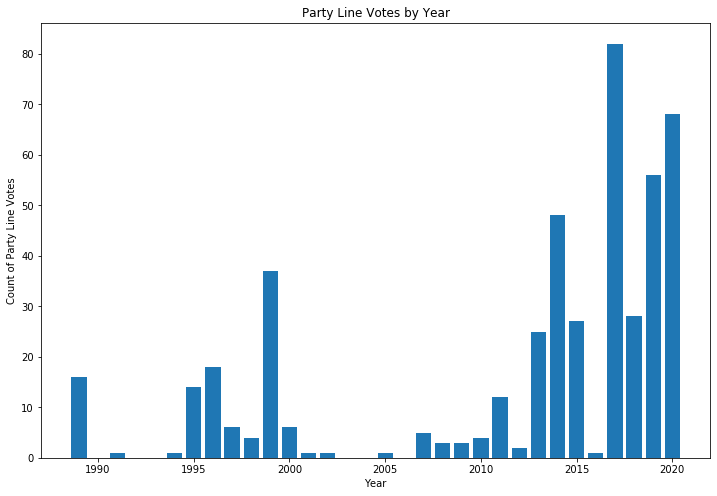

In [11]:
plt.figure(figsize=(12,8))
plt.title('Party Line Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count of Party Line Votes')
plt.bar(x=list(party_line_df.index), height=party_line_df['party_line_vote_count'])
plt.show()

This plot shows escalating partisanship in the Senate starting from around 2010 onwards.

## Analyzing partisanship by clustering of individual senators' voting records

### Prepare data

In [12]:
vote_by_rep_q = """
SELECT
	CONCAT(v.`year`, '-', v.`vote_number`) AS year_vote_number,
	v.`senator_id`,
	s.`name`,
	s.`party`,
	CASE
		WHEN v.`vote` = 'Nay' THEN -1
		WHEN v.`vote` = 'Yea' THEN 1
		ELSE 0
	END AS vote
FROM votes v
JOIN senators s ON s.`senator_id` = v.`senator_id`
WHERE v.`year` = {}
"""

In [13]:
with DBConnect('senate') as cnx:
    vr_1989 = pd.read_sql(sql=vote_by_rep_q.format(1989), con=cnx.cnx)
    vr_2020 = pd.read_sql(sql=vote_by_rep_q.format(2020), con=cnx.cnx)

In [14]:
def pivot_votes(df):
    pv = pd.pivot_table(df, index=['senator_id', 'name', 'party'], columns=['year_vote_number'], fill_value=0)
    return pv

In [15]:
df_89 = pivot_votes(vr_1989)
df_89.head()

vote             \
year_vote_number                                  1989-00001 1989-00002   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00003 1989-00004   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00005 1989-00006   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         \
year_vote_number                                  1989-00007 1989-00008   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat            1          1   
300009     Sen. Jeff Bingaman          Democrat            1          1   
300010     Sen. Christopher “Kit” Bond Republican          1          1   
300012     Sen. John Breaux            Democrat            1          1   

                                                                         ...  \
year_vote_number                                  1989-00009 1989-00010  ...   
senator_id name                        party                             ...   
300005     Sen. Max Baucus             Democrat            1          1  ...   
300008     Sen. Joseph Biden Jr.       Democrat            1          1  ...   
300009     Sen. Jeff Bingaman          Democrat            1          1  ...   
300010     Sen. Christopher “Kit” Bond Republican          1          1  ...   
300012     Sen. John Breaux            Democrat            1          1  ...   

                                                                         \
year_vote_number                                  1989-00303 1989-00304   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat            1          1   
300008     Sen. Joseph Biden Jr.       Democrat           -1          1   
300009     Sen. Jeff Bingaman          Democrat           -1          1   
300010     Sen. Christopher “Kit” Bond Republican         -1          1   
300012     Sen. John Breaux            Democrat           -1          1   

                                                                         \
year_vote_number                                  1989-00305 1989-00306   
senator_id name                        party                              
300005     Sen. Max Baucus             Democrat           -1         -1   
300008     Sen. Joseph Biden Jr.       Democrat           -1          1   
300009     Sen. Jeff Bingaman      

In [16]:
x_89 = df_89.to_numpy()

In [17]:
df_20 = pivot_votes(vr_2020)
x_20 = df_20.to_numpy()

### Apply Kmeans++

In [18]:
np.random.seed(seed=42)
kmeans = KMeans(n_clusters=2, init='k-means++')

In [19]:
km_89 = kmeans.fit(x_89)
magnitude_89 = kmeans.transform(x_89)
cluster_89 = kmeans.predict(x_89)

In [20]:
km_20 = kmeans.fit(x_20)
magnitude_20 = kmeans.transform(x_20)
cluster_20 = kmeans.predict(x_20)

In [21]:
df_89['cluster'] = cluster_89
df_89['mag_x'] = magnitude_89[:, 0]
df_89['mag_y'] = magnitude_89[:, 1]

In [22]:
df_20['cluster'] = cluster_20
df_20['mag_x'] = magnitude_20[:, 0]
df_20['mag_y'] = magnitude_20[:, 1]

### Plot Results

In [23]:
def plot_clusters(df):
    plt.scatter(x=df['mag_x'], y=df['mag_y'], c=df['cluster'])
    plt.plot()

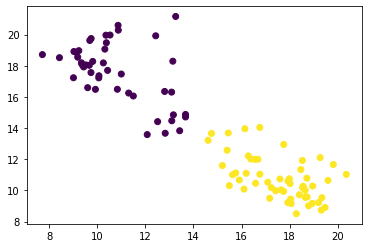

In [24]:
plot_clusters(df_89)

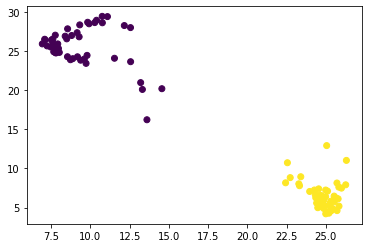

In [25]:
plot_clusters(df_20)

### Distance between centroids

In [26]:
def euc_dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [27]:
centroid_89_0 = (df_89.loc[df_89['cluster']==0, 'mag_x'].mean(), df_89.loc[df_89['cluster']==0, 'mag_y'].mean())
centroid_89_1 = (df_89.loc[df_89['cluster']==1, 'mag_x'].mean(), df_89.loc[df_89['cluster']==1, 'mag_y'].mean())

centroid_20_0 = (df_20.loc[df_20['cluster']==0, 'mag_x'].mean(), df_20.loc[df_20['cluster']==0, 'mag_y'].mean())
centroid_20_1 = (df_20.loc[df_20['cluster']==1, 'mag_x'].mean(), df_20.loc[df_20['cluster']==1, 'mag_y'].mean())

In [28]:
print('Distance between centroids, 1989: {:.2f}'.format(euc_dist(centroid_89_0, centroid_89_1)))
print('Distance between centroids, 2020: {:.2f}'.format(euc_dist(centroid_20_0, centroid_20_1)))

Distance between centroids, 1989: 9.62
Distance between centroids, 2020: 24.66


### Centroid Distance Over Time

In [29]:
def get_data(yr):
    q = vote_by_rep_q.format(yr)
    with DBConnect('senate') as cnx:
        df = pd.read_sql(sql=q, con=cnx.cnx)
    
    df = pivot_votes(df)
    
    return df

def get_centroids(df):
    x = df.to_numpy()
    km = KMeans(n_clusters=2, init='k-means++').fit(x)
    mags = km.transform(x)
    clusts = km.predict(x)
    df['mag_x'] = mags[:, 0]
    df['mag_y'] = mags[:, 1]
    df['cluster'] = clusts
    
    c0 = (df.loc[df['cluster']==0, 'mag_x'].mean(), df.loc[df['cluster']==0, 'mag_y'].mean())
    c1 = (df.loc[df['cluster']==1, 'mag_x'].mean(), df.loc[df['cluster']==1, 'mag_y'].mean())
    
    return (c0, c1)

def euc_dist2(points):
    p1 = points[0]
    p2 = points[1]
    
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def compose(*functions):
    return functools.reduce(lambda f, g: lambda x: g(f(x)), functions, lambda x: x)

centroid_distance = compose(get_data, get_centroids, euc_dist2)

In [30]:
dists = pd.DataFrame([[year, centroid_distance(year)] for year in range(1989, 2021)], columns=['year', 'dist'])

In [31]:
X = dists.to_numpy()[:, 0]
y = dists.to_numpy()[:, 1]

lr = LinearRegression()
lr = lr.fit(X.reshape(-1,1), y)

In [32]:
x_hat = np.linspace(1989, 2021, num=100).reshape(-1, 1)
y_hat = lr.predict(x_hat)

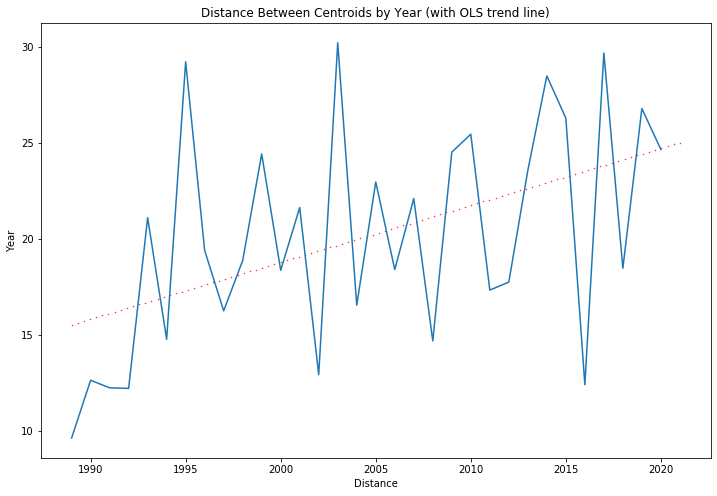

In [33]:
plt.figure(figsize=(12, 8))
plt.title('Distance Between Centroids by Year (with OLS trend line)')
plt.xlabel('Distance')
plt.ylabel('Year')
plt.plot(dists.set_index('year'))
plt.scatter(x=x_hat, y=y_hat, s=.2, color='r')
plt.show()

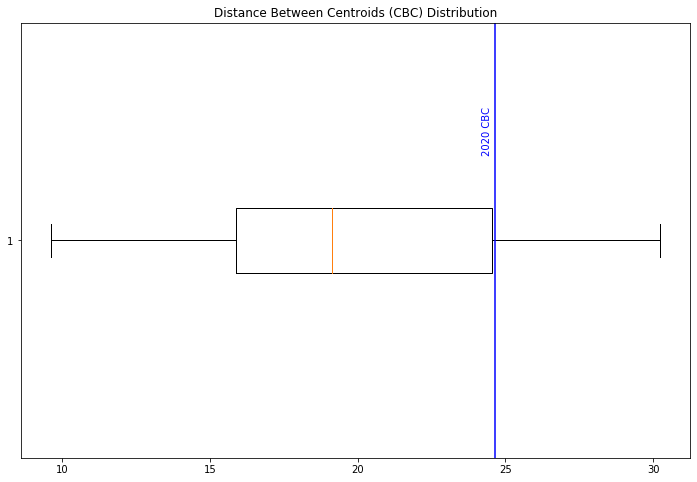

In [34]:
plt.figure(figsize=(12, 8))
plt.title('Distance Between Centroids (CBC) Distribution')
plt.annotate('2020 CBC', xy=(24.2,1.2), rotation=90, color='b')
plt.boxplot(dists['dist'], vert=False)
plt.axvline(x=dists.loc[dists['year']==2020, 'dist'].values[0], color='b', label='axvline - full height')

## Forecast

In [35]:
import plaidml.keras as pk
pk.install_backend()

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [36]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [37]:
n_features = 1
n_steps = 5

X, y = split_sequence(dists['dist'].to_list(), n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [38]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"


In [39]:
model.fit(X, y, epochs=200, verbose=0)

In [40]:
preds = model.predict(X[-5:])
preds

array([[15.488109],
       [24.670834],
       [18.482538],
       [25.98647 ],
       [19.673717]], dtype=float32)

In [41]:
preds = pd.DataFrame(list(zip(range(2021, 2026), preds.reshape(-1))), columns=['year', 'dist']).set_index('year')
preds

,dist
year,
2021,15.488109
2022,24.670834
2023,18.482538
2024,25.986469
2025,19.673717


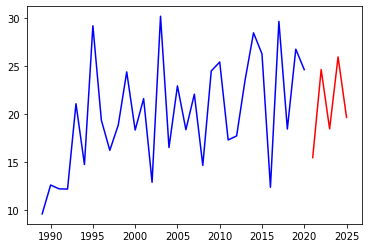

In [42]:
plt.plot(dists.set_index('year'), color='b')
plt.plot(preds, color='r')
plt.show()